http://www.cs.toronto.edu/~tijmen/affNIST/

In [12]:
from lib import load_batch
b = load_batch(1)

In [ ]:
b.image[0].shape

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(b.image[5], cmap='gray')

In [ ]:
image = b.image.reshape(-1, 40, 40, 1)

In [ ]:
from sklearn.model_selection import train_test_split

d = train_test_split(image, b.label_one_of_n, test_size=0.1, random_state=42)

In [ ]:
from convnet import get_convnet_model
model = get_convnet_model()


In [ ]:
from lib import train_convnet
train_convnet(model, d, 1)

In [3]:
from keras.metrics import categorical_accuracy
import tensorflow
# _, test_x, _, test_y = d
test_x, _, test_y, _ = d
test_x, test_y = test_x[0:1000], test_y[0:1000]
pred_y = model.predict(test_x)
with tensorflow.Session():
    acc = categorical_accuracy(tensorflow.convert_to_tensor(test_y), tensorflow.convert_to_tensor(pred_y)).eval()
print(acc)

Using TensorFlow backend.


NameError: name 'd' is not defined

In [ ]:
print(test_y[3])
print(pred_y[3])

In [2]:
from numpy import loadtxt
test = loadtxt("data/test-head.csv", skiprows=1, delimiter=',')

In [4]:
test[4]

array([ 4.,  0.,  0., ...,  0.,  0.,  0.])

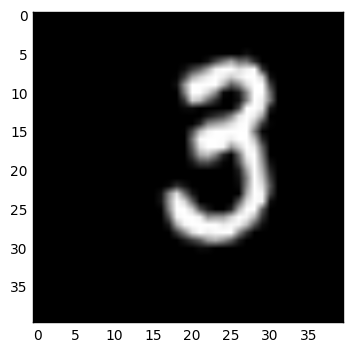

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(test[4, 1:].reshape(40, 40), cmap='gray')

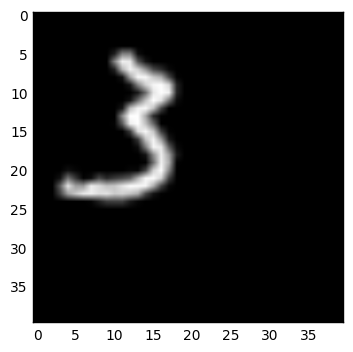

In [18]:
plt.imshow(b.image[3], cmap='gray')



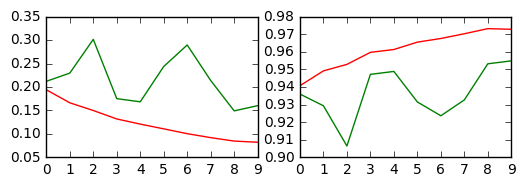

In [29]:
import json
import numpy
from matplotlib import pyplot as plt
with open("my_hist.json") as f:
    hist = json.load(f)
axis = numpy.arange(0, len(hist['val_categorical_accuracy']), 1)

plt.subplot(221)
plt.plot(axis, hist['loss'], 'r', axis, hist['val_loss'], 'g')

plt.subplot(222)
plt.plot(axis, hist['categorical_accuracy'], 'r', axis, hist['val_categorical_accuracy'], 'g')
